In [11]:
from utils import *
import numpy as np
import sys, os, random
import statistics


# from compare_locations import compare_locations

datadir = "../../data.upb/precis/04-precis-linux//"
linux_etaje = [ "0-linux-03-06-2022.json"]  


In [40]:
import numpy as np
from scipy.spatial.distance import *
from scipy.stats import ks_2samp, chisquare
import copy 

def real_braycurtis(u, v, ex):
    """
    Compute the Bray-Curtis distance between two 1-D arrays.
    Bray-Curtis distance is defined as
    .. math::
       \\sum{|u_i-v_i|} / \\sum{|u_i+v_i|}
    The Bray-Curtis distance is in the range [0, 1] if all coordinates are
    positive, and is undefined if the inputs are of length zero.
    """
    l1_diff = abs(u - v)
    l1_sum = abs(u + v)
    
    return (abs(ex) + l1_diff.sum()) / (abs(ex) + l1_sum.sum())


def precalculate(c): # c is a collection
    """ creates new fields to speed up distance comparisons 
          c.ufingerprint['wifirssi'][mac] = average dBm 
    """
    ufingerprint = {}
    ufingerprint['wifirssi'] = {}
    for f in c['fingerprints']:
        if not "wifi" in f.keys():
            continue
        for mac in f["wifi"].keys():
            avg_pow = np.average(f["wifi"][mac]['rssi']) # each fingerprint (direction) counts the same
            if not mac in ufingerprint["wifirssi"].keys():
                ufingerprint["wifirssi"][mac] = [avg_pow] 
            else:
                ufingerprint["wifirssi"][mac].append(avg_pow)
    for mac in ufingerprint["wifirssi"].keys():
        ufingerprint["wifirssi"][mac] = \
            np.average(adjust_rssi(ufingerprint["wifirssi"][mac])) #each fingerprint (direction) counts the same
    c['ufingerprint'] = ufingerprint
                
def merge_wifi_fingerprints1(flist):
    if len(flist) == 1:
        return flist[0]
    fingerprint = copy.deepcopy(flist[0])
    for f2 in copy.deepcopy(flist[1:]):
        if not "wifi" in f2.keys():
            continue
        for mac in f2["wifi"].keys():
            if not mac in fingerprint["wifi"].keys():
                fingerprint["wifi"][mac] = f2["wifi"][mac]
            else:
                fingerprint["wifi"][mac]['rssi'].extend(f2["wifi"][mac]['rssi'])
            fingerprint["wifi"][mac]['rssi'].sort()    
    return fingerprint

def compare_locations(c1, c2, simil_method = braycurtis,  selection = 'Average', dif = True):
    # precalculated with average, adjust_rssi  
    wifi1 = c1['ufingerprint']['wifirssi']
    wifi2 = c2['ufingerprint']['wifirssi']      
    
    common_aps = list(set(wifi1.keys()) & set(wifi2.keys()))
    # No APs in common -> similarity = 1
    if not common_aps:
        return 1.0

    if len(common_aps) * 10 <= len(wifi1.keys()) or len(common_aps) < 5:
        return 1.0

    aps1 = set(wifi1.keys()) - set(common_aps)
    aps2 = set(wifi2.keys()) - set(common_aps)
    rssi1 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    rssi2 = np.empty(len(common_aps) + len(aps1) + len(aps2), dtype=float)
    nap = 0   #  
    
    if selection == 'First':
        for ap in common_aps:
            rssi1.append(wifi1[ap]['rssi'][0])
            rssi2.append(wifi2[ap]['rssi'][0])

        # Make an average of all RSSI values
    if selection == 'Average':
        for ap in common_aps:
            rssi1[nap] = wifi1[ap]
            rssi2[nap] = wifi2[ap]
            print(rssi)
            nap = nap + 1
            
    if selection == 'Median':
        for ap in common_aps:
            rssi1.append(np.median(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.median(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Mean':
        for ap in common_aps:
            rssi1.append(np.mean(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.mean(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Std':
        for ap in common_aps:
            rssi1.append(np.std(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.std(adjust_rssi(wifi2[ap]['rssi'])))

    if selection == 'Max':
        for ap in common_aps:
            rssi1.append(np.max(adjust_rssi(wifi1[ap]['rssi'])))
            rssi2.append(np.max(adjust_rssi(wifi2[ap]['rssi'])))
            
    if selection == 'KS':
        for ap in common_aps:
            _, p = ks_2samp(wifi1[ap]['rssi'], wifi2[ap]['rssi'])
            rssi1.append(p)
            rssi2.append(1.0)

    if (dif == True) and (selection != 'KS'):
        if len(rssi1) > nap:
            rssi1[nap] = rssi1[0]
            rssi2[nap] = rssi2[0]
        rssi1 = np.diff(rssi1, append=rssi1[0])
        rssi2 = np.diff(rssi2, append=rssi1[0])   

   
    """
    p1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), wifi1.keys())))
    p2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), wifi2.keys())))
    pc1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), common_aps)))
    pc2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), common_aps)))
    po1 = np.mean(list(map(lambda a: np.mean(wifi1[a]['rssi']), aps1)))
    po2 = np.mean(list(map(lambda a: np.mean(wifi2[a]['rssi']), aps2)))        
    iou = len(common_aps) / \
        (len(aps1) + len(aps2) + len(common_aps))
    """
        
    for ap in aps1:
        rssi1[nap] = 1.0*wifi1[ap]
        rssi2[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
    for ap in aps2:
        rssi2[nap] = 1.0*wifi2[ap]
        rssi1[nap] = adjust_rssi(-95.0)[0]
        nap = nap + 1
        
    return simil_method(rssi1, rssi2)
    #return rssi1, rssi2




In [13]:
letaje = []
for e in linux_etaje: 
    json_file = os.path.join(datadir, e)
    etaj = load_dataset_json(json_file)
    for c in etaj:
        precalculate(c)
    letaje.append(etaj)
    

In [14]:
# compute similarities using neighbors < 7m 
# 

before = datetime.datetime.now()
etaje = letaje 
TP, FP, FN, R = 0, 0, 0, 0  
npct = 400 
fpd, posd = [], []
bd = []
bd_min = []
minra = []

for e in range(0,len(etaje)):
    bc_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    bc_matrix_dif_false = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    eu_dist_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    cos_matrix = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    cos_matrix_dif_false = np.zeros(shape=(len(etaje[e]), len(etaje[e])))
    
    mindisim = 1
    mindist = 100000
    for q in range(0,len(etaje[e])):
        for p in range(q+1,len(etaje[e])):
            if p > q:
                eu_dist = euclidean([etaje[e][q]['x'], etaje[e][q]['y'], etaje[e][q]['z']], 
                                        [etaje[e][p]['x'], etaje[e][p]['y'], etaje[e][p]['z']]) 
                if eu_dist > 20.0: 
                    continue
                bc = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=braycurtis)
                bc_false = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=False, simil_method=braycurtis)
                cos = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=True, simil_method=cosine)
                cos_false = compare_locations(etaje[e][q], etaje[e][p], selection = 'Average', \
                                              dif=False, simil_method=cosine)
                
                R, thr = 2.0, 0.29
                if bc < thr: 
                    if eu_dist < R:
                        TP = TP + 1 
                    else:
                        FP = FP + 1
                        fpd.append(eu_dist)
                    posd.append(eu_dist)    
                else:
                    if eu_dist < R:
                        FN = FN + 1
                           
                #print(p,q)
                bc_matrix[p][q] = bc
                bc_matrix[q][p] = bc
                bc_matrix_dif_false[p][q] = bc_false
                bc_matrix_dif_false[q][p] = bc_false
                eu_dist_matrix[p][q] = eu_dist
                eu_dist_matrix[q][p] = eu_dist
                cos_matrix[p][q] = cos
                cos_matrix[q][p] = cos
                cos_matrix_dif_false[p][q] = cos_false
                cos_matrix_dif_false[q][p] = cos_false



                                        
                bd.append([q, p, eu_dist, bc, cos, bc_false, cos_false])
                bd_min.append([q, p, round(eu_dist, 1), round(bc, 3)])
after = datetime.datetime.now()

print(f"R= {R} bc={thr} Precision= {TP*1.0/(TP+FP):.2f} Recall= {TP*1.0/(TP+FN):.2f} \
Pdist = {np.percentile(posd, [50, 95, 99])} ")
m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 1)
print(f"Slope = {m[0]:.2f}")

R= 2.0 bc=0.29 Precision= 0.52 Recall= 0.82 Pdist = [1.95692308 5.37348334 6.54374367] 
Slope = 0.06


Poly fit = [-1.01815839e+01  1.49570869e+01  8.35082708e+00  1.10846447e-05]


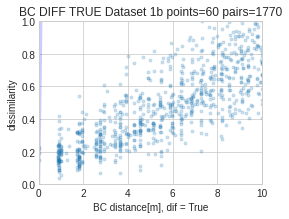

Poly fit = [ 7.40880024e+00 -2.16001296e+01  2.69352238e+01  1.65569644e-04]


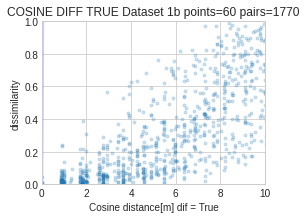

Poly fit = [-2.03523021e+01  2.92598319e+01  6.91893811e+00  1.10699083e-05]


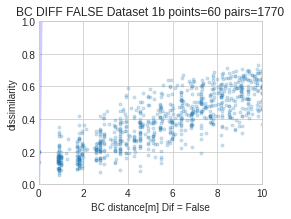

Poly fit = [ 3.88566634e+01 -6.15047683e+01  4.08691225e+01  1.27803266e-04]


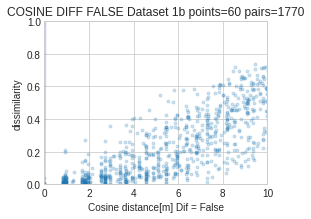

In [15]:
plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou  


# m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
# print(f"Slope = {m}")
# predict = np.poly1d(m)
# x_lin_reg = np.arange(0.0, 10.0, 0.1)
# y_lin_reg = predict(x_lin_reg)


dst = [r[2] for r in bd]  # distance 
dis = [r[3] for r in bd]  # 4 = cosine+diff 6=cosine+nodiff 
w = np.ones(len(dis))
dis = np.append(dis, 0)
dst = np.append(dst, 0)
w = np.append(w, len(dis))
degrees = 3

# dissim vs distance 

m = np.polyfit(dis , dst , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(min(dis), max(dis)*1.1, (max(dis) - min(dis))/20.0)
y_lin_reg = predict(x_lin_reg)



plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[3] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('BC distance[m], dif = True')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"BC DIFF TRUE Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
plt.ylim(0, 1.0)
plt.xlim(0, 10.0)
plt.show()
#fig.savefig(f"cosine-vs-distance-ds1b.svg", bbox_inches='tight')


dst = [r[2] for r in bd]  # distance 
dis = [r[4] for r in bd]  # 4 = cosine+diff 6=cosine+nodiff 
w = np.ones(len(dis))
dis = np.append(dis, 0)
dst = np.append(dst, 0)
w = np.append(w, len(dis))
degrees = 3

plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   
# m = np.polyfit([r[2] for r in bd] , [r[4] for r in bd], 2)
# print(f"Slope = {m}")
# predict = np.poly1d(m)
# x_lin_reg = np.arange(0.0, 10.0, 0.1)
# y_lin_reg = predict(x_lin_reg)
m = np.polyfit(dis , dst , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(min(dis), max(dis)*1.1, (max(dis) - min(dis))/20.0)
y_lin_reg = predict(x_lin_reg)



plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[4] for r in bd], ".", label='cos', alpha=0.2)
plt.xlabel('Cosine distance[m] dif = True')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"COSINE DIFF TRUE Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
plt.ylim(0, 1.0)
plt.xlim(0, 10.0)
plt.show()


dst = [r[2] for r in bd]  # distance 
dis = [r[5] for r in bd]  # 4 = cosine+diff 6=cosine+nodiff 
w = np.ones(len(dis))
dis = np.append(dis, 0)
dst = np.append(dst, 0)
w = np.append(w, len(dis))
degrees = 3

plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   
# m = np.polyfit([r[2] for r in bd] , [r[5] for r in bd], 2)
# print(f"Slope = {m}")
# predict = np.poly1d(m)
# x_lin_reg = np.arange(0.0, 10.0, 0.1)
# y_lin_reg = predict(x_lin_reg)
m = np.polyfit(dis , dst , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(min(dis), max(dis)*1.1, (max(dis) - min(dis))/20.0)
y_lin_reg = predict(x_lin_reg)

plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[5] for r in bd], ".", label='bc', alpha=0.2)
plt.xlabel('BC distance[m] Dif = False')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"BC DIFF FALSE Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
plt.ylim(0, 1.0)
plt.xlim(0, 10.0)
plt.show()
#fig.savefig(f"cosine-vs-distance-ds1b.svg", bbox_inches='tight')


dst = [r[2] for r in bd]  # distance 
dis = [r[6] for r in bd]  # 4 = cosine+diff 6=cosine+nodiff 
w = np.ones(len(dis))
dis = np.append(dis, 0)
dst = np.append(dst, 0)
w = np.append(w, len(dis))
degrees = 3

plt.style.use("seaborn-whitegrid")   
fig =  plt.figure(figsize=(4, 3))     # bc, realbc, iou   
# m = np.polyfit([r[2] for r in bd] , [r[6] for r in bd], 2)
# print(f"Slope = {m}")
# predict = np.poly1d(m)
# x_lin_reg = np.arange(0.0, 10.0, 0.1)
# y_lin_reg = predict(x_lin_reg)
m = np.polyfit(dis , dst , degrees, w=w)
print(f"Poly fit = {m}")
predict = np.poly1d(m)
x_lin_reg = np.arange(min(dis), max(dis)*1.1, (max(dis) - min(dis))/20.0)
y_lin_reg = predict(x_lin_reg)

plt.plot(x_lin_reg, y_lin_reg, c = 'b', alpha=0.2, linewidth=3)

plt.plot([r[2] for r in bd] , [r[6] for r in bd], ".", label='cos', alpha=0.2)
plt.xlabel('Cosine distance[m] Dif = False')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"COSINE DIFF FALSE Dataset 1b points={len(etaje[0])} pairs={len(bd)}")
plt.ylim(0, 1.0)
plt.xlim(0, 10.0)
plt.show()

In [16]:
def get_calculated_distance_from_dissimilarity(dissim):
    m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
    predict = np.poly1d(m)
    x_lin_reg = np.arange(0.0, 10.0, 0.1)
    y_lin_reg = predict(x_lin_reg)
    
    y_lin_reg = np.trunc(y_lin_reg*10**3)/(10**3)
    x_lin_reg = np.trunc(x_lin_reg*10**1)/(10**1)
    
    for d in range(0,len(y_lin_reg)):
        if y_lin_reg[d] == dissim:
            return x_lin_reg[d]

def get_calculated_dissimilarity_from_distance(distance):
    m = np.polyfit([r[2] for r in bd] , [r[3] for r in bd], 2)
    predict = np.poly1d(m)
    x_lin_reg = np.arange(0.0, 10.0, 0.1)
    y_lin_reg = predict(x_lin_reg)
    
    y_lin_reg = np.trunc(y_lin_reg*10**3)/(10**3)
    x_lin_reg = np.trunc(x_lin_reg*10**1)/(10**1)
    
    for d in range(0,len(x_lin_reg)):
        if x_lin_reg[d] == distance:
            return y_lin_reg[d]

def get_real_dissimilarities_from_distance(distance):
    dissim = []
    for r in bd_min:
        if round(r[2],1) == distance:
            dissim.append(r[3])
            
    return dissim

def get_real_distances_from_dissimilarity(dissim):
    distances = []
    for r in bd:
        if round(r[3],3) == dissim:
            distances.append(r[2])
            
    return distances

    #for r in bd:
    #    print(r[2], r[3])

In [17]:
#dissimilarity_function(0.1)
#print("Real Dissim: ", get_dissimilarities_from_distance(2.0))
#print("Our Calculated Dissim: ", my_dissimilarity_function(2.0))

real_dissim = get_real_dissimilarities_from_distance(9.8)
real_dist = get_real_distances_from_dissimilarity(0.25)
print("REAL dissim: ", real_dissim)
print("REAL distances: ", real_dist)

print("Calculated dissim: ", get_calculated_dissimilarity_from_distance(9.8))
print("Calculated distance: ", get_calculated_distance_from_dissimilarity(0.119))




print("Numpy Standard deviation: ", np.std(real_dissim))
print("Numpy Variance: ", np.var(real_dissim))
print("Mean: ", sum(real_dissim)/len(real_dissim))
print("Statistics variance: ", statistics.variance(real_dissim))
print("Statistics pvariance: ", statistics.pvariance(real_dissim))
print("Statistics Standard deviation: ", statistics.pstdev(real_dissim))
print("Statistics Standard deviation: ", statistics.stdev(real_dissim))



#print(bd)

REAL dissim:  [0.907, 0.901, 0.846, 0.643, 0.611, 0.706, 0.557, 0.848, 0.908, 0.856, 1.016, 0.982, 0.437, 0.555, 0.966, 0.653]
REAL distances:  [2.7342857142857184, 5.828857836100429, 0.9085714285714275]
Calculated dissim:  0.79
Calculated distance:  0.9
Numpy Standard deviation:  0.1731076254819527
Numpy Variance:  0.029966249999999993
Mean:  0.7744999999999999
Statistics variance:  0.031964
Statistics pvariance:  0.029966249999999996
Statistics Standard deviation:  0.1731076254819527
Statistics Standard deviation:  0.17878478682483026


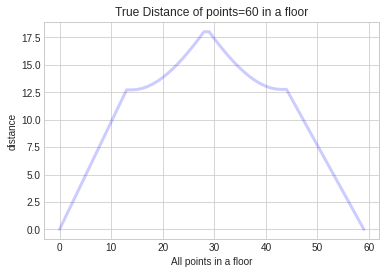

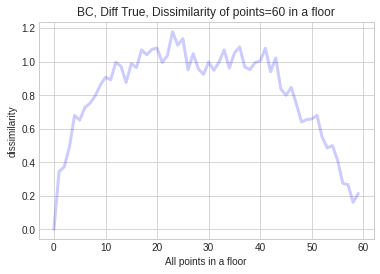

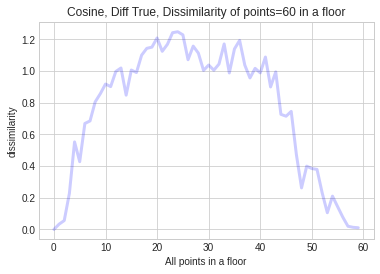

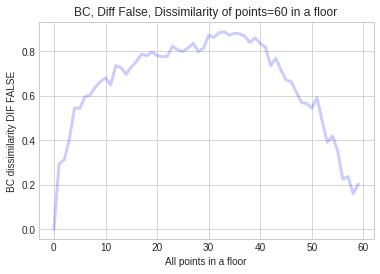

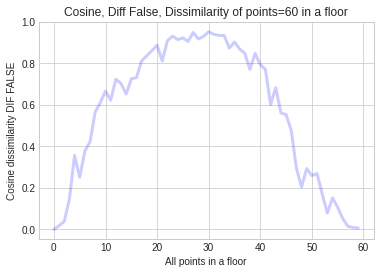

[[0 0 0]
 [0 0 1]
 [1 1 1]
 [0 1 0]
 [0 1 1]]
[[0. 1. 3. 1. 2.]
 [1. 0. 2. 2. 1.]
 [3. 2. 0. 2. 1.]
 [1. 2. 2. 0. 1.]
 [2. 1. 1. 1. 0.]]
[[ 0.9847767   0.84738596]
 [ 0.81047787 -0.37601578]
 [-1.104849   -1.06040621]
 [-0.29311254  0.87364759]
 [-0.39729303 -0.28461157]]


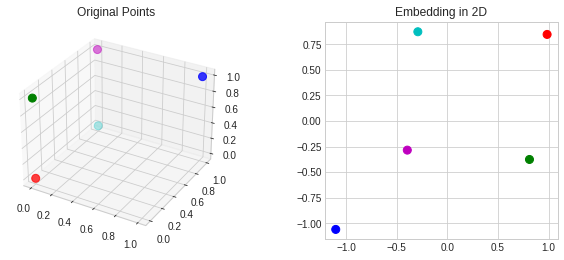

In [18]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances


plt.plot(range(0,len(eu_dist_matrix[0])), eu_dist_matrix[0], c = 'b', alpha=0.2, linewidth=3)

plt.xlabel('All points in a floor')
plt.ylabel('distance')
plt.grid(True)
plt.title(f"True Distance of points={len(etaje[0])} in a floor")
plt.show()


plt.plot(range(0,len(bc_matrix[0])), bc_matrix[0], c = 'b', alpha=0.2, linewidth=3)
plt.xlabel('All points in a floor')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"BC, Diff True, Dissimilarity of points={len(etaje[0])} in a floor")
plt.show()

plt.plot(range(0,len(cos_matrix[0])), cos_matrix[0], c = 'b', alpha=0.2, linewidth=3)
plt.xlabel('All points in a floor')
plt.ylabel('dissimilarity')
plt.grid(True)
plt.title(f"Cosine, Diff True, Dissimilarity of points={len(etaje[0])} in a floor")
plt.show()

plt.plot(range(0,len(bc_matrix_dif_false[0])), bc_matrix_dif_false[0], c = 'b', alpha=0.2, linewidth=3)
plt.xlabel('All points in a floor')
plt.ylabel('BC dissimilarity DIF FALSE')
plt.grid(True)
plt.title(f"BC, Diff False, Dissimilarity of points={len(etaje[0])} in a floor")
plt.show()

plt.plot(range(0,len(cos_matrix_dif_false[0])), cos_matrix_dif_false[0], c = 'b', alpha=0.2, linewidth=3)
plt.xlabel('All points in a floor')
plt.ylabel('Cosine dissimilarity DIF FALSE')
plt.grid(True)
plt.title(f"Cosine, Diff False, Dissimilarity of points={len(etaje[0])} in a floor")
plt.show()






X = np.array([[0, 0, 0], [0, 0, 1], [1, 1, 1], [0, 1, 0], [0, 1, 1]])
dist_manhattan = manhattan_distances(X)
mds = MDS(dissimilarity='precomputed', random_state=0)
X_transform_L1 = mds.fit_transform(dist_manhattan)

print(X)
print(dist_manhattan)
print(X_transform_L1)

#print(X)
#print(dist_manhattan)
#print(bc_matrix)

#print(bc_matrix[1])
#print(len(bc_matrix[0]))

colors = ['r', 'g', 'b', 'c', 'm']
size = [64, 64, 64, 64, 64]
fig = plt.figure(2, (10,4))
ax = fig.add_subplot(121, projection='3d')
plt.scatter(X[:,0], X[:,1], zs=X[:,2], s=size, c=colors)
plt.title('Original Points')

ax = fig.add_subplot(122)
plt.scatter(X_transform_L1[:,0], X_transform_L1[:,1], s=size, c=colors)
plt.title('Embedding in 2D')
fig.subplots_adjust(wspace=.4, hspace=0.5)
plt.show()


11.795290576731329


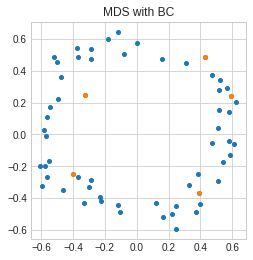

21.3782701737084


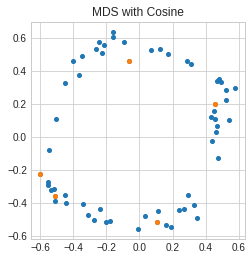

9.455214936751911


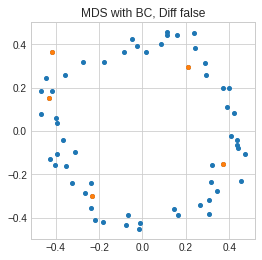

9.53668853794051


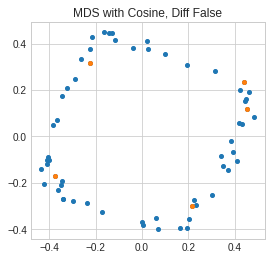

In [42]:
mds_1 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_1 = mds_1.fit_transform(bc_matrix)
print(mds_1.stress_)
size = [50] * len(dissim_transform_1)
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
ax = fig.add_subplot(121)
plt.scatter(dissim_transform_1[:,0], dissim_transform_1[:,1], s=64, marker = '.')
plt.scatter(dissim_transform_1[0::14][:,0], dissim_transform_1[0::14][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with BC')
plt.show()



dissim_transform_2 = mds_1.fit_transform(cos_matrix)
print(mds_1.stress_)
size = [50] * len(dissim_transform_2)
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
ax = fig.add_subplot(121)
plt.scatter(dissim_transform_2[:,0], dissim_transform_2[:,1], s=64, marker = '.')
plt.scatter(dissim_transform_2[0::14][:,0], dissim_transform_2[0::14][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Cosine')
plt.show()


dissim_transform_3 = mds_1.fit_transform(bc_matrix_dif_false)
print(mds_1.stress_)
size = [50] * len(dissim_transform_3)
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_3[:,0], dissim_transform_3[:,1], s=64, marker = '.')
plt.scatter(dissim_transform_3[0::14][:,0], dissim_transform_3[0::14][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with BC, Diff false')
plt.show()


dissim_transform_4 = mds_1.fit_transform(cos_matrix_dif_false)
print(mds_1.stress_)
size = [50] * len(dissim_transform_4)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_4[:,0], dissim_transform_4[:,1], s=64, marker = '.')
plt.scatter(dissim_transform_4[0::14][:,0], dissim_transform_4[0::14][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Cosine, Diff False')
plt.show()


# mark 0, 21, 42, 63, 85
#inspect bray-curtis
#issue: dissim over 1
# MDS cu weight?
# MDS cu distanțe mici
# procrustes (rotație, scalare, translație)


#print(dissim_transform)

Latura1: 0 - 13
Latura2: 14 - 28
Latura3: 29 - 43
Latura4: 44 - 59

0.10852477608650207


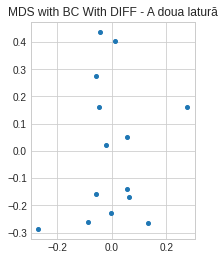

0.050127933799808184


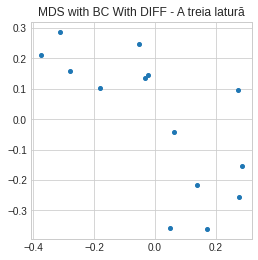

0.18018187619905773


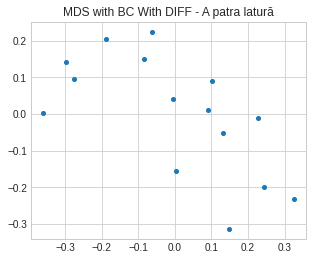

1.739915459528059


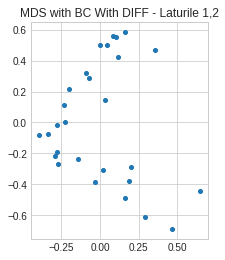

1.6976679862738724


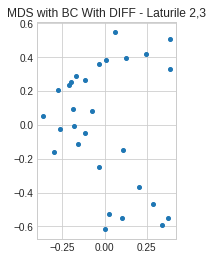

1.0552069242683522


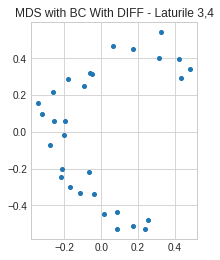

6.55763524274472


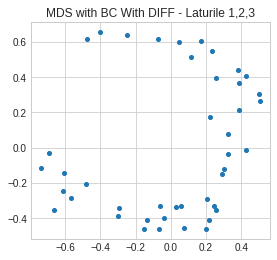

5.270277938038633


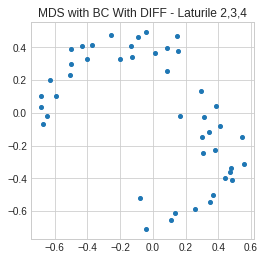

11.380618763048826


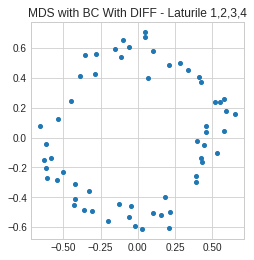

In [46]:
cos_st_line_matrix_dif_false = bc_matrix[14:28,14:28]
#print(cos_st_line_matrix_dif_false)
mds_4 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_4 = mds_4.fit_transform(cos_st_line_matrix_dif_false)
print(mds_4.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_4[:,0], dissim_transform_4[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - A doua latură')
plt.show()

cos_st_line_matrix_dif_false = bc_matrix[29:43,29:43]
#print(cos_st_line_matrix_dif_false)
mds_5 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_5 = mds_5.fit_transform(cos_st_line_matrix_dif_false)
print(mds_5.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_5[:,0], dissim_transform_5[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - A treia latură')
plt.show()

cos_st_line_matrix_dif_false = bc_matrix[44:59,44:59]
#print(cos_st_line_matrix_dif_false)
mds_6 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_6 = mds_6.fit_transform(cos_st_line_matrix_dif_false)
print(mds_6.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_6[:,0], dissim_transform_6[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - A patra latură')
plt.show()



cos_st_line_matrix_dif_false = bc_matrix[0:28, 0:28]
#print(cos_st_line_matrix_dif_false)
mds_7 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_7 = mds_7.fit_transform(cos_st_line_matrix_dif_false)
print(mds_7.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_7[:,0], dissim_transform_7[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 1,2')
plt.show()


cos_st_line_matrix_dif_false = bc_matrix[14:43, 14:43]
#print(cos_st_line_matrix_dif_false)
mds_8 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_8 = mds_8.fit_transform(cos_st_line_matrix_dif_false)
print(mds_8.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_8[:,0], dissim_transform_8[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 2,3')
plt.show()


cos_st_line_matrix_dif_false = bc_matrix[29:59, 29:59]
#print(cos_st_line_matrix_dif_false)
mds_9 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_9 = mds_9.fit_transform(cos_st_line_matrix_dif_false)
print(mds_9.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_9[:,0], dissim_transform_9[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 3,4')
plt.show()


cos_st_line_matrix_dif_false = bc_matrix[0:43, 0:43]
#print(cos_st_line_matrix_dif_false)
mds_10 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_10 = mds_10.fit_transform(cos_st_line_matrix_dif_false)
print(mds_10.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_10[:,0], dissim_transform_10[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 1,2,3')
plt.show()

cos_st_line_matrix_dif_false = bc_matrix[14:59, 14:59]
#print(cos_st_line_matrix_dif_false)
mds_11 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_11 = mds_11.fit_transform(cos_st_line_matrix_dif_false)
print(mds_11.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_11[:,0], dissim_transform_11[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 2,3,4')
plt.show()


cos_st_line_matrix_dif_false = bc_matrix[0:59, 0:59]
#print(cos_st_line_matrix_dif_false)
mds_12 = MDS(dissimilarity='precomputed', random_state=0)
dissim_transform_12 = mds_11.fit_transform(cos_st_line_matrix_dif_false)
print(mds_11.stress_)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_12[:,0], dissim_transform_12[:,1], s=64, marker = '.')
plt.title('MDS with BC With DIFF - Laturile 1,2,3,4')
plt.show()


0.12311893196330215


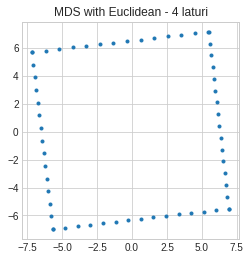

0.08963040443196868


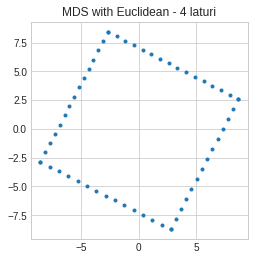

0.7707129608380339


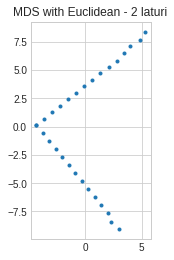

0.18342291783311288


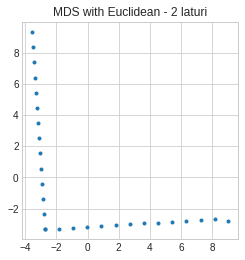

0.2012640719319867


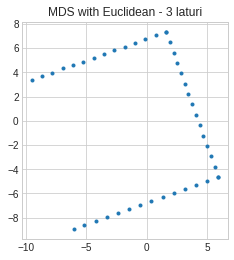

0.27577029995931035


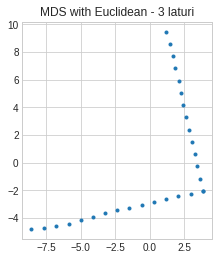

In [27]:
#### MDS for Euclidean Distanec ####

mds = MDS(n_components = 2, dissimilarity = 'precomputed', random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix)
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 4 laturi')
plt.show()

mds = MDS(n_components=2, dissimilarity = 'precomputed', n_init = 500, random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix)
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 4 laturi')
plt.show()


### 2 laturi

mds = MDS(n_components=2, dissimilarity = 'precomputed', random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix[14:43, 14:43])
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 2 laturi')
plt.show()

mds = MDS(n_components=2, dissimilarity = 'precomputed', n_init = 500, random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix[0:28, 0:28])
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 2 laturi')
plt.show()


### 3 laturi ###

mds = MDS(n_components=2, dissimilarity = 'precomputed', random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix[0:43, 0:43])
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 3 laturi')
plt.show()


mds = MDS(n_components=2, dissimilarity = 'precomputed', n_init = 500, random_state = 0)
dissim_transform = mds.fit_transform(eu_dist_matrix[14:43, 14:43])
print(mds.stress_)
size = [50] * len(dissim_transform)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform[:,0], dissim_transform[:,1], marker = '.')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 3 laturi')
plt.show()



In [ ]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    

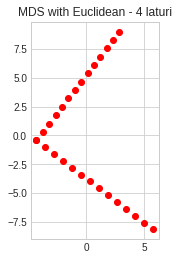

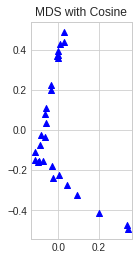

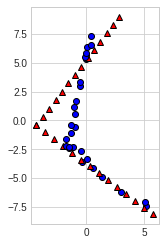

In [38]:
#Predicted vs real position
start=0
end=28

mds = MDS(n_components=2, dissimilarity = 'precomputed', n_init = 2, eps=1e-9, random_state = 0, max_iter = 5000)
# clf = PCA(n_components=2)

dissim_transform_real = mds.fit_transform(eu_dist_matrix[start:end, start:end])
size = [50] * len(dissim_transform_real)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_real[:,0], dissim_transform_real[:,1], marker = 'o', color='red')
#plt.scatter(dissim_transform[0::22][:,0], dissim_transform[0::22][:,1], s=64, marker = '.', cmap='Greens_r')
plt.title('MDS with Euclidean - 4 laturi')
plt.show()



#dissim_transform_computed = mds.fit(cos_matrix_dif_false[start:end, start:end])
#pos = mds.fit(cos_matrix_dif_false[start:end, start:end]).embedding_

dissim_transform_computed = mds.fit_transform(cos_matrix_dif_false[start:end, start:end])
#dissim_transform_computed = clf.fit_transform(dissim_transform_computed)

#size = [50] * len(dissim_transform_computed)
#fig = plt.figure(2, (10,4))
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.gca().set_aspect("equal")
plt.scatter(dissim_transform_computed[:,0], dissim_transform_computed[:,1], marker = '^', color='blue')
#plt.scatter(dissim_transform_computed[:,0], dissim_transform_computed[:,1], marker = '^', color='blue')
plt.title('MDS with Cosine')
plt.show()

#dissim_transform_real = clf.fit_transform(dissim_transform_real)
#dissim_transform_computed = clf.fit_transform(dissim_transform_computed)
#dissim_transform_computed = rotate(dissim_transform_computed, 180)

for i in range(0, len(dissim_transform_computed)):
    plt.gca().set_aspect("equal")
    #plt.xlim(-10, 10)
    #plt.ylim(-10, 10)
    #plt.plot([dissim_transform_real[i][0], 10*dissim_transform_computed[i][0]],[dissim_transform_real[i][1], 10*dissim_transform_computed[i][1]] , 'o-',  c='blue', mfc='red', mec='k')
    #plt.scatter(dissim_transform_computed[:,0], dissim_transform_computed[:,1], marker = '^', color='blue')
    plt.plot(dissim_transform_real[i][0], dissim_transform_real[i][1] , '^',  c='blue', mfc='red', mec='k')
    plt.plot(15 * dissim_transform_computed[i][0], 15 * dissim_transform_computed[i][1] , 'o',  c='red', mfc='blue', mec='k')
